## Importing Libraries

In [716]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from sklearn.svm import SVR

## Reading File and Exploration

In [717]:
df = pd.read_csv("C:/Users/DELL/Desktop/Bioinformatics/COVID19-N20-master/DateWorld/2020-05-18/DroppedDay/Australia.csv", sep=',')
df.head()

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,Australia,2/29/20,25,0,10,0,1
1,Australia,3/1/20,27,1,2,1,2
2,Australia,3/2/20,30,1,3,0,3
3,Australia,3/3/20,39,1,9,0,4
4,Australia,3/4/20,52,2,13,1,5


In [718]:
df.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day
count,80.000000,80.000000,80.000000,80.000000,80.0000
mean,4360.025000,46.900000,88.162500,1.237500,40.5000
std,2844.904092,38.441341,123.765544,1.744748,23.2379
min,25.000000,0.000000,0.000000,0.000000,1.0000
25%,763.500000,6.750000,12.750000,0.000000,20.7500
50%,6059.000000,50.500000,23.000000,1.000000,40.5000
75%,6746.000000,89.500000,110.000000,2.000000,60.2500
max,7068.000000,99.000000,497.000000,8.000000,80.0000


In [719]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
country          80 non-null object
date             80 non-null object
confirmed        80 non-null int64
deaths           80 non-null int64
new_confirmed    80 non-null int64
new_deaths       80 non-null int64
tagged_day       80 non-null int64
dtypes: int64(5), object(2)
memory usage: 4.5+ KB


In [720]:
# Making new column named days_since_lockdown and assigning 1 to day when lockdown took place
# Information about which day lockdown started was from following link:
# https://www.theguardian.com/world/2020/may/02/australias-coronavirus-lockdown-the-first-50-days 

df_new = df.copy(deep=True)

count = 0
df_new['days_since_lockdown'] = count
for index, row in df_new.iterrows():
    if(row["date"] == '3/24/20'):
        count += 1
        df_new.loc[index, 'days_since_lockdown'] = count 
    elif(count != 0):
        count += 1
        df_new.loc[index, 'days_since_lockdown'] = count
print (df_new)

      country     date  confirmed  deaths  new_confirmed  new_deaths  \
0   Australia  2/29/20         25       0             10           0   
1   Australia   3/1/20         27       1              2           1   
2   Australia   3/2/20         30       1              3           0   
3   Australia   3/3/20         39       1              9           0   
4   Australia   3/4/20         52       2             13           1   
..        ...      ...        ...     ...            ...         ...   
75  Australia  5/14/20       7019      98             30           0   
76  Australia  5/15/20       7035      98             16           0   
77  Australia  5/16/20       7044      98              9           0   
78  Australia  5/17/20       7054      99             10           1   
79  Australia  5/18/20       7068      99             14           0   

    tagged_day  days_since_lockdown  
0            1                    0  
1            2                    0  
2            3       

In [721]:
# Getting the index when days_since_lockdown is 1
temp = np.where(df_new["days_since_lockdown"] == 1)
print (temp)

(array([24], dtype=int64),)


On tagged day 24 was the first day of lockdown

In [722]:
# Days before days_since_lockdown assigned negative values (-1 for each day)
reverse_count = 0
for i in reversed(range(23)):
    reverse_count = reverse_count - 1
    df_new.loc[i, 'days_since_lockdown'] = reverse_count
print(df_new)        

      country     date  confirmed  deaths  new_confirmed  new_deaths  \
0   Australia  2/29/20         25       0             10           0   
1   Australia   3/1/20         27       1              2           1   
2   Australia   3/2/20         30       1              3           0   
3   Australia   3/3/20         39       1              9           0   
4   Australia   3/4/20         52       2             13           1   
..        ...      ...        ...     ...            ...         ...   
75  Australia  5/14/20       7019      98             30           0   
76  Australia  5/15/20       7035      98             16           0   
77  Australia  5/16/20       7044      98              9           0   
78  Australia  5/17/20       7054      99             10           1   
79  Australia  5/18/20       7068      99             14           0   

    tagged_day  days_since_lockdown  
0            1                  -23  
1            2                  -22  
2            3       

In [723]:
# To confirm assignment of days since lockdown is correct
# 3/24/20 was day 1
df_new.iloc[17:30,:]

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
17,Australia,3/17/20,452,5,75,2,18,-6
18,Australia,3/18/20,568,6,116,1,19,-5
19,Australia,3/19/20,681,6,113,0,20,-4
20,Australia,3/20/20,791,7,110,1,21,-3
21,Australia,3/21/20,1071,7,280,0,22,-2
22,Australia,3/22/20,1549,7,478,0,23,-1
23,Australia,3/23/20,1682,7,133,0,24,0
24,Australia,3/24/20,2044,8,362,1,25,1
25,Australia,3/25/20,2364,8,320,0,26,2
26,Australia,3/26/20,2810,13,446,5,27,3


In [724]:
df_new['date'] = df_new['date'].astype(str) + "20"
print (df_new)

      country       date  confirmed  deaths  new_confirmed  new_deaths  \
0   Australia  2/29/2020         25       0             10           0   
1   Australia   3/1/2020         27       1              2           1   
2   Australia   3/2/2020         30       1              3           0   
3   Australia   3/3/2020         39       1              9           0   
4   Australia   3/4/2020         52       2             13           1   
..        ...        ...        ...     ...            ...         ...   
75  Australia  5/14/2020       7019      98             30           0   
76  Australia  5/15/2020       7035      98             16           0   
77  Australia  5/16/2020       7044      98              9           0   
78  Australia  5/17/2020       7054      99             10           1   
79  Australia  5/18/2020       7068      99             14           0   

    tagged_day  days_since_lockdown  
0            1                  -23  
1            2                  -22

In [725]:
# Getting the date in YYYY-MM-DD format
df_new['date'] = pd.to_datetime(df_new['date'])
print (df_new)

      country       date  confirmed  deaths  new_confirmed  new_deaths  \
0   Australia 2020-02-29         25       0             10           0   
1   Australia 2020-03-01         27       1              2           1   
2   Australia 2020-03-02         30       1              3           0   
3   Australia 2020-03-03         39       1              9           0   
4   Australia 2020-03-04         52       2             13           1   
..        ...        ...        ...     ...            ...         ...   
75  Australia 2020-05-14       7019      98             30           0   
76  Australia 2020-05-15       7035      98             16           0   
77  Australia 2020-05-16       7044      98              9           0   
78  Australia 2020-05-17       7054      99             10           1   
79  Australia 2020-05-18       7068      99             14           0   

    tagged_day  days_since_lockdown  
0            1                  -23  
1            2                  -22

In [726]:
df_new.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
count,80.000000,80.000000,80.000000,80.000000,80.0000,80.0000
mean,4360.025000,46.900000,88.162500,1.237500,40.5000,16.5000
std,2844.904092,38.441341,123.765544,1.744748,23.2379,23.2379
min,25.000000,0.000000,0.000000,0.000000,1.0000,-23.0000
25%,763.500000,6.750000,12.750000,0.000000,20.7500,-3.2500
50%,6059.000000,50.500000,23.000000,1.000000,40.5000,16.5000
75%,6746.000000,89.500000,110.000000,2.000000,60.2500,36.2500
max,7068.000000,99.000000,497.000000,8.000000,80.0000,56.0000


In [727]:
df2 = pd.read_csv("C:/Users/DELL/Desktop/Bioinformatics/COVID19-N20-master/DateWorld/2020-05-18/DroppedDay/Italy.csv", sep=',')
df2.head()

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,Italy,2/21/20,20,1,17,1,1
1,Italy,2/22/20,62,2,42,1,2
2,Italy,2/23/20,155,3,93,1,3
3,Italy,2/24/20,229,7,74,4,4
4,Italy,2/25/20,322,10,93,3,5


In [728]:
df2.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day
count,88.000000,88.000000,88.000000,88.000000,88.000000
mean,114352.443182,14853.795455,2566.852273,363.715909,44.500000
std,84596.166666,12001.477561,1844.330982,261.814664,25.547342
min,20.000000,1.000000,0.000000,0.000000,1.000000
25%,20282.750000,1397.250000,884.750000,162.000000,22.750000
50%,126790.000000,15624.500000,2318.500000,358.500000,44.500000
75%,198109.750000,26727.250000,4050.750000,575.750000,66.250000
max,225886.000000,32007.000000,6557.000000,919.000000,88.000000


In [729]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 7 columns):
country          88 non-null object
date             88 non-null object
confirmed        88 non-null int64
deaths           88 non-null int64
new_confirmed    88 non-null int64
new_deaths       88 non-null int64
tagged_day       88 non-null int64
dtypes: int64(5), object(2)
memory usage: 4.9+ KB


In [730]:
# Making new column named days_since_lockdown and assigning 1 to day when lockdown took place
# Information about which day lockdown started was from following link:
# https://www.dw.com/en/coronavirus-what-are-the-lockdown-measures-across-europe/a-52905137

df2_new = df2.copy(deep=True)

count_2 = 0
df2_new['days_since_lockdown'] = count_2
for index, row in df2_new.iterrows():
    if(row["date"] == '3/9/20'):
        count_2 += 1
        df2_new.loc[index, 'days_since_lockdown'] = count_2
    elif(count_2 != 0):
        count_2 += 1
        df2_new.loc[index, 'days_since_lockdown'] = count_2
print (df2_new)

   country     date  confirmed  deaths  new_confirmed  new_deaths  tagged_day  \
0    Italy  2/21/20         20       1             17           1           1   
1    Italy  2/22/20         62       2             42           1           2   
2    Italy  2/23/20        155       3             93           1           3   
3    Italy  2/24/20        229       7             74           4           4   
4    Italy  2/25/20        322      10             93           3           5   
..     ...      ...        ...     ...            ...         ...         ...   
83   Italy  5/14/20     223096   31368            992         262          84   
84   Italy  5/15/20     223885   31610            789         242          85   
85   Italy  5/16/20     224760   31763            875         153          86   
86   Italy  5/17/20     225435   31908            675         145          87   
87   Italy  5/18/20     225886   32007            451          99          88   

    days_since_lockdown  
0

In [731]:
# Getting the index when days_since_lockdown is 1
temp2 = np.where(df2_new["days_since_lockdown"] == 1)
print (temp2) 

(array([17], dtype=int64),)


On tagged day 17 was the first day of lockdown

In [732]:
# Days before days_since_lockdown assigned negative values (-1 for each day)
reverse_count_2 = 0
for j in reversed(range(16)):
    reverse_count_2 = reverse_count_2 - 1
    df2_new.loc[j, 'days_since_lockdown'] = reverse_count_2
print(df2_new)  

   country     date  confirmed  deaths  new_confirmed  new_deaths  tagged_day  \
0    Italy  2/21/20         20       1             17           1           1   
1    Italy  2/22/20         62       2             42           1           2   
2    Italy  2/23/20        155       3             93           1           3   
3    Italy  2/24/20        229       7             74           4           4   
4    Italy  2/25/20        322      10             93           3           5   
..     ...      ...        ...     ...            ...         ...         ...   
83   Italy  5/14/20     223096   31368            992         262          84   
84   Italy  5/15/20     223885   31610            789         242          85   
85   Italy  5/16/20     224760   31763            875         153          86   
86   Italy  5/17/20     225435   31908            675         145          87   
87   Italy  5/18/20     225886   32007            451          99          88   

    days_since_lockdown  
0

In [733]:
# To confirm assignment of days since lockdown is correct
# 3/9/20 was day 1
df2_new.iloc[10:22,:]

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
10,Italy,3/2/20,2036,52,342,18,11,-6
11,Italy,3/3/20,2502,79,466,27,12,-5
12,Italy,3/4/20,3089,107,587,28,13,-4
13,Italy,3/5/20,3858,148,769,41,14,-3
14,Italy,3/6/20,4636,197,778,49,15,-2
15,Italy,3/7/20,5883,233,1247,36,16,-1
16,Italy,3/8/20,7375,366,1492,133,17,0
17,Italy,3/9/20,9172,463,1797,97,18,1
18,Italy,3/10/20,10149,631,977,168,19,2
19,Italy,3/11/20,12462,827,2313,196,20,3


In [734]:
df2_new['date'] = df2_new['date'].astype(str) + "20"
print (df2_new)

   country       date  confirmed  deaths  new_confirmed  new_deaths  \
0    Italy  2/21/2020         20       1             17           1   
1    Italy  2/22/2020         62       2             42           1   
2    Italy  2/23/2020        155       3             93           1   
3    Italy  2/24/2020        229       7             74           4   
4    Italy  2/25/2020        322      10             93           3   
..     ...        ...        ...     ...            ...         ...   
83   Italy  5/14/2020     223096   31368            992         262   
84   Italy  5/15/2020     223885   31610            789         242   
85   Italy  5/16/2020     224760   31763            875         153   
86   Italy  5/17/2020     225435   31908            675         145   
87   Italy  5/18/2020     225886   32007            451          99   

    tagged_day  days_since_lockdown  
0            1                  -16  
1            2                  -15  
2            3                  -

In [735]:
# Getting the date in YYYY-MM-DD format
df2_new['date'] = pd.to_datetime(df2_new['date'])
print (df2_new)

   country       date  confirmed  deaths  new_confirmed  new_deaths  \
0    Italy 2020-02-21         20       1             17           1   
1    Italy 2020-02-22         62       2             42           1   
2    Italy 2020-02-23        155       3             93           1   
3    Italy 2020-02-24        229       7             74           4   
4    Italy 2020-02-25        322      10             93           3   
..     ...        ...        ...     ...            ...         ...   
83   Italy 2020-05-14     223096   31368            992         262   
84   Italy 2020-05-15     223885   31610            789         242   
85   Italy 2020-05-16     224760   31763            875         153   
86   Italy 2020-05-17     225435   31908            675         145   
87   Italy 2020-05-18     225886   32007            451          99   

    tagged_day  days_since_lockdown  
0            1                  -16  
1            2                  -15  
2            3                  -

In [736]:
df2_new.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,114352.443182,14853.795455,2566.852273,363.715909,44.500000,27.500000
std,84596.166666,12001.477561,1844.330982,261.814664,25.547342,25.547342
min,20.000000,1.000000,0.000000,0.000000,1.000000,-16.000000
25%,20282.750000,1397.250000,884.750000,162.000000,22.750000,5.750000
50%,126790.000000,15624.500000,2318.500000,358.500000,44.500000,27.500000
75%,198109.750000,26727.250000,4050.750000,575.750000,66.250000,49.250000
max,225886.000000,32007.000000,6557.000000,919.000000,88.000000,71.000000


In [737]:
df3 = pd.read_csv("C:/Users/DELL/Desktop/Bioinformatics/COVID19-N20-master/DateWorld/2020-05-18/DroppedDay/Germany.csv", sep=',')
df3.head()

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,Germany,2/26/20,27,0,10,0,1
1,Germany,2/27/20,46,0,19,0,2
2,Germany,2/28/20,48,0,2,0,3
3,Germany,2/29/20,79,0,31,0,4
4,Germany,3/1/20,130,0,51,0,5


In [738]:
df3.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day
count,83.000000,83.000000,83.000000,83.000000,83.000000
mean,91672.072289,3057.650602,2126.915663,96.421687,42.000000
std,69142.510725,3073.381948,1966.613979,103.548989,24.103942
min,27.000000,0.000000,2.000000,-31.000000,1.000000
25%,10792.000000,26.000000,575.000000,4.000000,21.500000
50%,107663.000000,2016.000000,1470.000000,76.000000,42.000000
75%,159335.000000,6220.000000,3322.500000,154.500000,62.500000
max,176551.000000,8003.000000,6933.000000,510.000000,83.000000


We see negative min value for new_deaths that is not possible

In [739]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
country          83 non-null object
date             83 non-null object
confirmed        83 non-null int64
deaths           83 non-null int64
new_confirmed    83 non-null int64
new_deaths       83 non-null int64
tagged_day       83 non-null int64
dtypes: int64(5), object(2)
memory usage: 4.7+ KB


In [740]:
# Making new column named days_since_lockdown and assigning 1 to day when lockdown took place
# Information about which day lockdown started was from following link:
# https://www.dw.com/en/coronavirus-what-are-the-lockdown-measures-across-europe/a-52905137

df3_new = df3.copy(deep=True)

count_3 = 0
df3_new['days_since_lockdown'] = count_3
for index, row in df3_new.iterrows():
    if(row["date"] == '3/22/20'):
        count_3 += 1
        df3_new.loc[index, 'days_since_lockdown'] = count_3 
    elif(count_3 != 0):
        count_3 += 1
        df3_new.loc[index, 'days_since_lockdown'] = count_3
print (df3_new)

    country     date  confirmed  deaths  new_confirmed  new_deaths  \
0   Germany  2/26/20         27       0             10           0   
1   Germany  2/27/20         46       0             19           0   
2   Germany  2/28/20         48       0              2           0   
3   Germany  2/29/20         79       0             31           0   
4   Germany   3/1/20        130       0             51           0   
..      ...      ...        ...     ...            ...         ...   
78  Germany  5/14/20     174478    7884            380          23   
79  Germany  5/15/20     175233    7897            755          13   
80  Germany  5/16/20     175752    7938            519          41   
81  Germany  5/17/20     176369    7962            617          24   
82  Germany  5/18/20     176551    8003            182          41   

    tagged_day  days_since_lockdown  
0            1                    0  
1            2                    0  
2            3                    0  
3      

In [741]:
# Getting the index when days_since_lockdown is 1
temp3 = np.where(df3_new["days_since_lockdown"] == 1)
print (temp3) 

(array([25], dtype=int64),)


On tagged day 25 was the first day of lockdown

In [742]:
# Days before days_since_lockdown assigned negative values (-1 for each day)
reverse_count_3 = 0
for k in reversed(range(24)):
    reverse_count_3 = reverse_count_3 - 1
    df3_new.loc[k, 'days_since_lockdown'] = reverse_count_3
print(df3_new)  

    country     date  confirmed  deaths  new_confirmed  new_deaths  \
0   Germany  2/26/20         27       0             10           0   
1   Germany  2/27/20         46       0             19           0   
2   Germany  2/28/20         48       0              2           0   
3   Germany  2/29/20         79       0             31           0   
4   Germany   3/1/20        130       0             51           0   
..      ...      ...        ...     ...            ...         ...   
78  Germany  5/14/20     174478    7884            380          23   
79  Germany  5/15/20     175233    7897            755          13   
80  Germany  5/16/20     175752    7938            519          41   
81  Germany  5/17/20     176369    7962            617          24   
82  Germany  5/18/20     176551    8003            182          41   

    tagged_day  days_since_lockdown  
0            1                  -24  
1            2                  -23  
2            3                  -22  
3      

In [743]:
# To confirm assignment of days since lockdown is correct
# 3/22/20 was day 1
df3_new.iloc[16:30,:]

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
16,Germany,3/13/20,3675,7,1597,4,17,-8
17,Germany,3/14/20,4585,9,910,2,18,-7
18,Germany,3/15/20,5795,11,1210,2,19,-6
19,Germany,3/16/20,7272,17,1477,6,20,-5
20,Germany,3/17/20,9257,24,1985,7,21,-4
21,Germany,3/18/20,12327,28,3070,4,22,-3
22,Germany,3/19/20,15320,44,2993,16,23,-2
23,Germany,3/20/20,19848,67,4528,23,24,-1
24,Germany,3/21/20,22213,84,2365,17,25,0
25,Germany,3/22/20,24873,94,2660,10,26,1


In [744]:
# Finding the row with negative new_deaths
for index, row in df3_new.iterrows():
    if(row["new_deaths"] < 0):
        print(row, index)

country                Germany
date                   4/11/20
confirmed               124908
deaths                    2736
new_confirmed             2737
new_deaths                 -31
tagged_day                  46
days_since_lockdown         21
Name: 45, dtype: object 45


In [745]:
# Dropping the row with negative new_deaths (row 45) and confirming it has been dropped
# Also, for the row 46, adjusting the new_confirmed and new_deaths to match with row 44

for index, row in df3_new.iterrows():
    if(row["new_deaths"] < 0):
        df3_new = df3_new.drop([index], axis=0)
    if(row["date"] == "4/12/20"):
        df3_new.loc[index, "new_deaths"] = df3_new.loc[index, "deaths"] - df3_new.loc[index-2, "deaths"]
        df3_new.loc[index, "new_confirmed"] = df3_new.loc[index, "confirmed"] - df3_new.loc[index-2, "confirmed"]
print(df3_new.iloc[40:50,:])

    country     date  confirmed  deaths  new_confirmed  new_deaths  \
40  Germany   4/6/20     103374    1810           3251         226   
41  Germany   4/7/20     107663    2016           4289         206   
42  Germany   4/8/20     113296    2349           5633         333   
43  Germany   4/9/20     118181    2607           4885         258   
44  Germany  4/10/20     122171    2767           3990         160   
46  Germany  4/12/20     127854    3022           5683         255   
47  Germany  4/13/20     130072    3194           2218         172   
48  Germany  4/14/20     131359    3294           1287         100   
49  Germany  4/15/20     134753    3804           3394         510   
50  Germany  4/16/20     137698    4052           2945         248   

    tagged_day  days_since_lockdown  
40          41                   16  
41          42                   17  
42          43                   18  
43          44                   19  
44          45                   20  
4

In [746]:
df3_new['date'] = df3_new['date'].astype(str) + "20"
print (df3_new)

    country       date  confirmed  deaths  new_confirmed  new_deaths  \
0   Germany  2/26/2020         27       0             10           0   
1   Germany  2/27/2020         46       0             19           0   
2   Germany  2/28/2020         48       0              2           0   
3   Germany  2/29/2020         79       0             31           0   
4   Germany   3/1/2020        130       0             51           0   
..      ...        ...        ...     ...            ...         ...   
78  Germany  5/14/2020     174478    7884            380          23   
79  Germany  5/15/2020     175233    7897            755          13   
80  Germany  5/16/2020     175752    7938            519          41   
81  Germany  5/17/2020     176369    7962            617          24   
82  Germany  5/18/2020     176551    8003            182          41   

    tagged_day  days_since_lockdown  
0            1                  -24  
1            2                  -23  
2            3       

In [747]:
# Getting the date in YYYY-MM-DD format
df3_new['date'] = pd.to_datetime(df3_new['date'])
print (df3_new)

    country       date  confirmed  deaths  new_confirmed  new_deaths  \
0   Germany 2020-02-26         27       0             10           0   
1   Germany 2020-02-27         46       0             19           0   
2   Germany 2020-02-28         48       0              2           0   
3   Germany 2020-02-29         79       0             31           0   
4   Germany 2020-03-01        130       0             51           0   
..      ...        ...        ...     ...            ...         ...   
78  Germany 2020-05-14     174478    7884            380          23   
79  Germany 2020-05-15     175233    7897            755          13   
80  Germany 2020-05-16     175752    7938            519          41   
81  Germany 2020-05-17     176369    7962            617          24   
82  Germany 2020-05-18     176551    8003            182          41   

    tagged_day  days_since_lockdown  
0            1                  -24  
1            2                  -23  
2            3       

In [748]:
df3_new.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,91266.756098,3061.573171,2152.853659,97.597561,41.951220,16.951220
std,69468.726312,3092.086195,2014.417939,102.565470,24.248153,24.248153
min,27.000000,0.000000,2.000000,0.000000,1.000000,-24.000000
25%,10024.500000,25.000000,565.000000,4.500000,21.250000,-3.750000
50%,105518.500000,1913.000000,1378.500000,76.500000,41.500000,16.500000
75%,159623.500000,6267.000000,3622.750000,155.250000,62.750000,37.750000
max,176551.000000,8003.000000,6933.000000,510.000000,83.000000,58.000000


Negative value of new_deaths has been removed successfully

In [749]:
df4 = pd.read_csv("C:/Users/DELL/Desktop/Bioinformatics/COVID19-N20-master/DateWorld/2020-05-18/DroppedDay/Iran.csv", sep=',')
df4.head()

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,Iran,2/22/20,28,5,10,1,1
1,Iran,2/23/20,43,8,15,3,2
2,Iran,2/24/20,61,12,18,4,3
3,Iran,2/25/20,95,16,34,4,4
4,Iran,2/26/20,139,19,44,3,5


In [750]:
df4.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day
count,87.000000,87.000000,87.000000,87.000000,87.000000
mean,54251.011494,3383.517241,1407.747126,81.068966,44.000000
std,40674.024530,2510.890488,767.160427,45.817838,25.258662
min,28.000000,5.000000,10.000000,1.000000,1.000000
25%,13333.500000,667.500000,998.500000,48.500000,22.500000
50%,58226.000000,3603.000000,1297.000000,80.000000,44.000000
75%,90976.500000,5758.000000,1784.000000,122.500000,65.500000
max,122492.000000,7057.000000,3186.000000,158.000000,87.000000


In [751]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 7 columns):
country          87 non-null object
date             87 non-null object
confirmed        87 non-null int64
deaths           87 non-null int64
new_confirmed    87 non-null int64
new_deaths       87 non-null int64
tagged_day       87 non-null int64
dtypes: int64(5), object(2)
memory usage: 4.9+ KB


In [752]:
# Making new column named days_since_lockdown and assigning 1 to day when lockdown took place
# Information about which day lockdown started was from following link:
# https://www.deccanherald.com/international/world-news-politics/iran-imposes-lockdown-to-check-all-citizens-for-coronavirus-813679.html

df4_new = df4.copy(deep=True)

count_4 = 0
df4_new['days_since_lockdown'] = count_4
for index, row in df4_new.iterrows():
    if(row["date"] == '3/14/20'):
        count_4 += 1
        df4_new.loc[index, 'days_since_lockdown'] = count_4
    elif(count_4 != 0):
        count_4 += 1
        df4_new.loc[index, 'days_since_lockdown'] = count_4
print (df4_new)

   country     date  confirmed  deaths  new_confirmed  new_deaths  tagged_day  \
0     Iran  2/22/20         28       5             10           1           1   
1     Iran  2/23/20         43       8             15           3           2   
2     Iran  2/24/20         61      12             18           4           3   
3     Iran  2/25/20         95      16             34           4           4   
4     Iran  2/26/20        139      19             44           3           5   
..     ...      ...        ...     ...            ...         ...         ...   
82    Iran  5/14/20     114533    6854           1808          71          83   
83    Iran  5/15/20     116635    6902           2102          48          84   
84    Iran  5/16/20     118392    6937           1757          35          85   
85    Iran  5/17/20     120198    6988           1806          51          86   
86    Iran  5/18/20     122492    7057           2294          69          87   

    days_since_lockdown  
0

In [753]:
# Getting the index when days_since_lockdown is 1
temp4 = np.where(df4_new["days_since_lockdown"] == 1)
print (temp4) 

(array([21], dtype=int64),)


On tagged day 21 was the first day of lockdown

In [754]:
# Days before days_since_lockdown assigned negative values (-1 for each day)
reverse_count_4 = 0
for l in reversed(range(20)):
    reverse_count_4 = reverse_count_4 - 1
    df4_new.loc[l, 'days_since_lockdown'] = reverse_count_4
print(df4_new)  

   country     date  confirmed  deaths  new_confirmed  new_deaths  tagged_day  \
0     Iran  2/22/20         28       5             10           1           1   
1     Iran  2/23/20         43       8             15           3           2   
2     Iran  2/24/20         61      12             18           4           3   
3     Iran  2/25/20         95      16             34           4           4   
4     Iran  2/26/20        139      19             44           3           5   
..     ...      ...        ...     ...            ...         ...         ...   
82    Iran  5/14/20     114533    6854           1808          71          83   
83    Iran  5/15/20     116635    6902           2102          48          84   
84    Iran  5/16/20     118392    6937           1757          35          85   
85    Iran  5/17/20     120198    6988           1806          51          86   
86    Iran  5/18/20     122492    7057           2294          69          87   

    days_since_lockdown  
0

In [755]:
# To confirm assignment of days since lockdown is correct
# 3/14/2020 was day 1
df4_new.iloc[15:25,:]

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
15,Iran,3/8/20,6566,194,743,49,16,-5
16,Iran,3/9/20,7161,237,595,43,17,-4
17,Iran,3/10/20,8042,291,881,54,18,-3
18,Iran,3/11/20,9000,354,958,63,19,-2
19,Iran,3/12/20,10075,429,1075,75,20,-1
20,Iran,3/13/20,11364,514,1289,85,21,0
21,Iran,3/14/20,12729,611,1365,97,22,1
22,Iran,3/15/20,13938,724,1209,113,23,2
23,Iran,3/16/20,14991,853,1053,129,24,3
24,Iran,3/17/20,16169,988,1178,135,25,4


In [756]:
df4_new['date'] = df4_new['date'].astype(str) + "20"
print (df4_new)

   country       date  confirmed  deaths  new_confirmed  new_deaths  \
0     Iran  2/22/2020         28       5             10           1   
1     Iran  2/23/2020         43       8             15           3   
2     Iran  2/24/2020         61      12             18           4   
3     Iran  2/25/2020         95      16             34           4   
4     Iran  2/26/2020        139      19             44           3   
..     ...        ...        ...     ...            ...         ...   
82    Iran  5/14/2020     114533    6854           1808          71   
83    Iran  5/15/2020     116635    6902           2102          48   
84    Iran  5/16/2020     118392    6937           1757          35   
85    Iran  5/17/2020     120198    6988           1806          51   
86    Iran  5/18/2020     122492    7057           2294          69   

    tagged_day  days_since_lockdown  
0            1                  -20  
1            2                  -19  
2            3                  -

In [757]:
# Getting the date in YYYY-MM-DD format
df4_new['date'] = pd.to_datetime(df4_new['date'])
print (df4_new)

   country       date  confirmed  deaths  new_confirmed  new_deaths  \
0     Iran 2020-02-22         28       5             10           1   
1     Iran 2020-02-23         43       8             15           3   
2     Iran 2020-02-24         61      12             18           4   
3     Iran 2020-02-25         95      16             34           4   
4     Iran 2020-02-26        139      19             44           3   
..     ...        ...        ...     ...            ...         ...   
82    Iran 2020-05-14     114533    6854           1808          71   
83    Iran 2020-05-15     116635    6902           2102          48   
84    Iran 2020-05-16     118392    6937           1757          35   
85    Iran 2020-05-17     120198    6988           1806          51   
86    Iran 2020-05-18     122492    7057           2294          69   

    tagged_day  days_since_lockdown  
0            1                  -20  
1            2                  -19  
2            3                  -

In [758]:
df4_new.describe()

,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,54251.011494,3383.517241,1407.747126,81.068966,44.000000,23.000000
std,40674.024530,2510.890488,767.160427,45.817838,25.258662,25.258662
min,28.000000,5.000000,10.000000,1.000000,1.000000,-20.000000
25%,13333.500000,667.500000,998.500000,48.500000,22.500000,1.500000
50%,58226.000000,3603.000000,1297.000000,80.000000,44.000000,23.000000
75%,90976.500000,5758.000000,1784.000000,122.500000,65.500000,44.500000
max,122492.000000,7057.000000,3186.000000,158.000000,87.000000,66.000000


### For the four countries, we see the following day on which lockdown took place (day since confirmed case first crossed 20 i.e when tagged day was 1)     
    
Australia : tagged day 24 was the first day of lockdown    
Italy : tagged day 17 was the first day of lockdown    
Germany : tagged day 25 was the first day of lockdown    
Iran : tagged day 21 was the first day of lockdown    

## Data Visualization 

### For Iran,

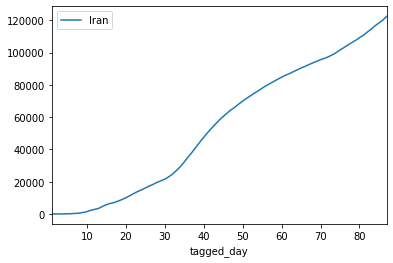

In [759]:
fig, ax = plt.subplots()
df4_new.plot(ax = ax, x = 'tagged_day', y = 'confirmed', label = 'Iran', kind = 'line')

The curve for number of confirmed cases with respect to tagged day seems to be on the rise for Iran

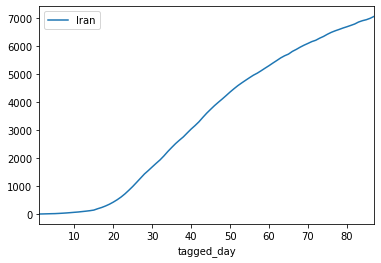

In [760]:
fig, ax = plt.subplots()
df4_new.plot(ax = ax, x = 'tagged_day', y = 'deaths', label = 'Iran', kind = 'line')

The curve for number of new deaths with respect to tagged day seems to be on the rise for Iran

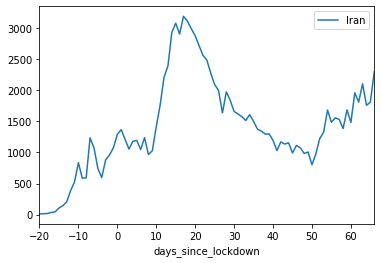

In [761]:
fig, ax = plt.subplots()
df4_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_confirmed', label = 'Iran', kind = 'line')

There seems to be a second wave for number of new confirmed cases with respect to days since lockdown that seems to be on the rise for Iran

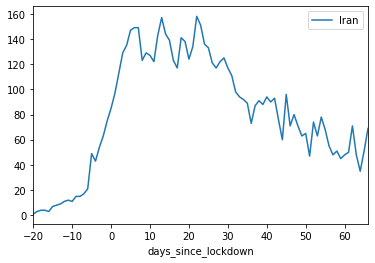

In [762]:
fig, ax = plt.subplots()
df4_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_deaths', label = 'Iran', kind = 'line')

The curve for number of new deaths with respect to days since lockdown seems to be on the fall for Iran

### For Germany,

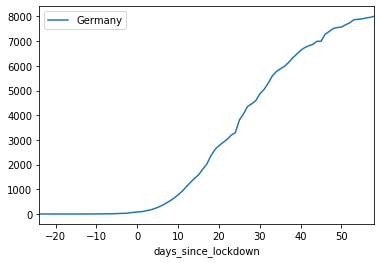

In [763]:
fig, ax = plt.subplots()
df3_new.plot(ax = ax, x = 'days_since_lockdown', y = 'deaths', label = 'Germany', kind = 'line')

The curve for number of deaths with respect to days since lockdown seems to be increasing for Germany

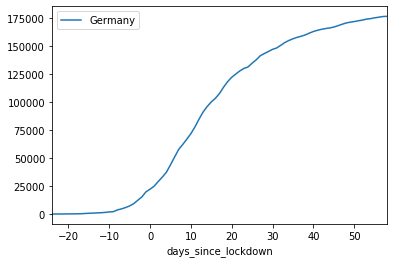

In [764]:
fig, ax = plt.subplots()
df3_new.plot(ax = ax, x = 'days_since_lockdown', y = 'confirmed', label = 'Germany', kind = 'line')

The curve for number of confirmed cases with respect to days since lockdown seems to be on the rise for Germany

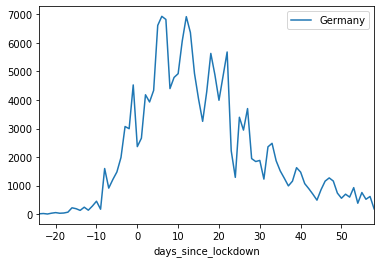

In [765]:
fig, ax = plt.subplots()
df3_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_confirmed', label = 'Germany', kind = 'line')

The curve for number of new confirmed cases with respect to days since lockdown has been falling down (looks like around 0 new confirmed cases in the last few days) for Germany

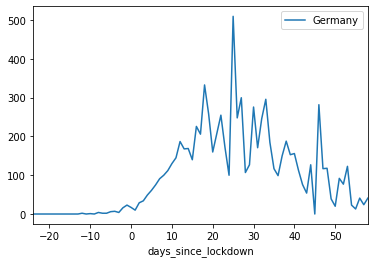

In [766]:
fig, ax = plt.subplots()
df3_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_deaths', label = 'Germany', kind = 'line')

The curve for number of new deaths with respect to days since lockdown seems to be falling down for Germany

### For Italy,

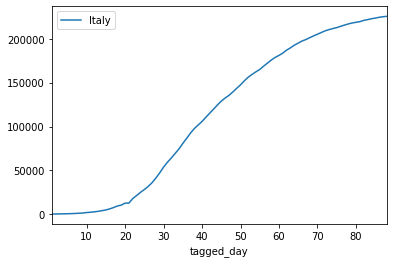

In [767]:
fig, ax = plt.subplots()
df2_new.plot(ax = ax, x = 'tagged_day', y = 'confirmed', label = 'Italy', kind = 'line')

The curve for number of confirmed cases with respect to tagged day seems to be increasing for Italy

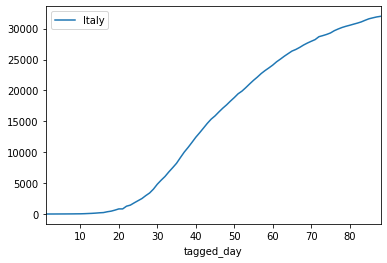

In [768]:
fig, ax = plt.subplots()
df2_new.plot(ax = ax, x = 'tagged_day', y = 'deaths', label = 'Italy', kind = 'line')

The curve for number of deaths with respect to tagged day seems to be increasing for Italy

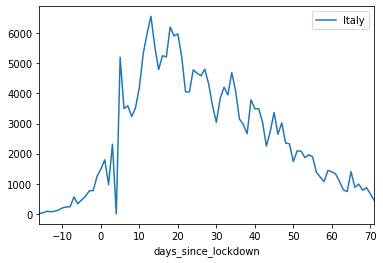

In [769]:
fig, ax = plt.subplots()
df2_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_confirmed', label = 'Italy', kind = 'line')

The curve for number of new confirmed cases with respect to days since lockdown seems to be falling down for Italy

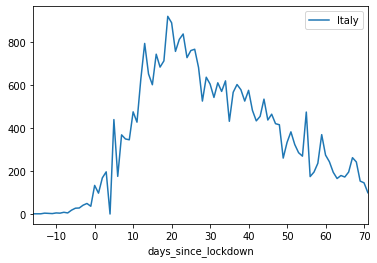

In [770]:
fig, ax = plt.subplots()
df2_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_deaths', label = 'Italy', kind = 'line')

The curve for number of new deaths with respect to days since lockdown seems to be falling down for Italy

### For Australia,

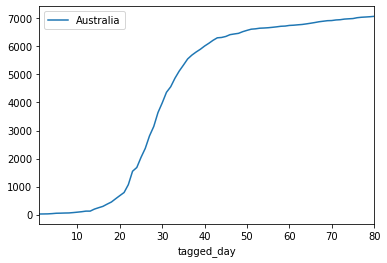

In [771]:
fig, ax = plt.subplots()
df_new.plot(ax = ax, x = 'tagged_day', y = 'confirmed', label = 'Australia', kind = 'line')

The curve for number of confirmed cases with respect to tagged day seems to be flattening out for Australia

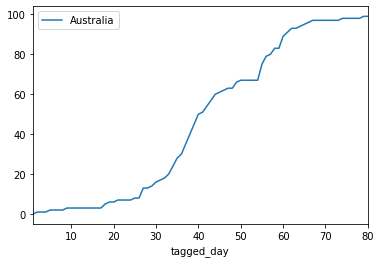

In [772]:
fig, ax = plt.subplots()
df_new.plot(ax = ax, x = 'tagged_day', y = 'deaths', label = 'Australia', kind = 'line')

The curve for number of deaths with respect to tagged day seems to be flattening out for Australia

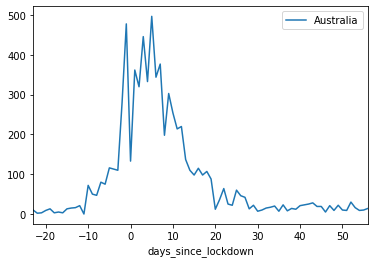

In [773]:
fig, ax = plt.subplots()
df_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_confirmed', label = 'Australia', kind = 'line')

The curve for number of new confirmed cases with respect to days since lockdown seems to be closer to 0 for Australia since last few days (very few confirmed cases lately)

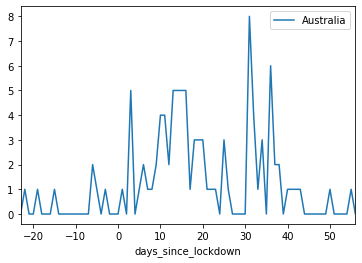

In [774]:
fig, ax = plt.subplots()
df_new.plot(ax = ax, x = 'days_since_lockdown', y = 'new_deaths', label = 'Australia', kind = 'line')

The curve for number of new deaths with respect to days since lockdown seems to be around 0 for Australia since last few days

### Population for the four countries:     
    
Australia : 25,499,884 (Median Age = 38)    
Italy : 60,461,826 (Median Age = 47)    
Germany : 83,783,942 (Median Age = 46)    
Iran : 83,992,949 (Median Age = 32)   

Information received from https://www.worldometers.info/world-population/population-by-country/

In [775]:
# Normalizing confirmed cases
df_new["confirmed_cases_rate"] = (df_new["confirmed"] / 25499884) * 100000
df2_new["confirmed_cases_rate"] = (df2_new["confirmed"] / 60461826) * 100000
df3_new["confirmed_cases_rate"] = (df3_new["confirmed"] / 83783942) * 100000
df4_new["confirmed_cases_rate"] = (df4_new["confirmed"] / 83992949) * 100000
print(df_new)
print(df2_new)
print(df3_new)
print(df4_new)

      country       date  confirmed  deaths  new_confirmed  new_deaths  \
0   Australia 2020-02-29         25       0             10           0   
1   Australia 2020-03-01         27       1              2           1   
2   Australia 2020-03-02         30       1              3           0   
3   Australia 2020-03-03         39       1              9           0   
4   Australia 2020-03-04         52       2             13           1   
..        ...        ...        ...     ...            ...         ...   
75  Australia 2020-05-14       7019      98             30           0   
76  Australia 2020-05-15       7035      98             16           0   
77  Australia 2020-05-16       7044      98              9           0   
78  Australia 2020-05-17       7054      99             10           1   
79  Australia 2020-05-18       7068      99             14           0   

    tagged_day  days_since_lockdown  confirmed_cases_rate  
0            1                  -23              0.

In [776]:
# Normalizing deaths
df_new["death_rate"] = (df_new["deaths"] / 25499884) * 100000
df2_new["death_rate"] = (df2_new["deaths"] / 60461826) * 100000
df3_new["death_rate"] = (df3_new["deaths"] / 83783942) * 100000
df4_new["death_rate"] = (df4_new["deaths"] / 83992949) * 100000
print(df_new)
print(df2_new)
print(df3_new)
print(df4_new)

      country       date  confirmed  deaths  new_confirmed  new_deaths  \
0   Australia 2020-02-29         25       0             10           0   
1   Australia 2020-03-01         27       1              2           1   
2   Australia 2020-03-02         30       1              3           0   
3   Australia 2020-03-03         39       1              9           0   
4   Australia 2020-03-04         52       2             13           1   
..        ...        ...        ...     ...            ...         ...   
75  Australia 2020-05-14       7019      98             30           0   
76  Australia 2020-05-15       7035      98             16           0   
77  Australia 2020-05-16       7044      98              9           0   
78  Australia 2020-05-17       7054      99             10           1   
79  Australia 2020-05-18       7068      99             14           0   

    tagged_day  days_since_lockdown  confirmed_cases_rate  death_rate  
0            1                  -23    

Text(0, 0.5, 'Number of Confirmed Cases per 100,000 population')

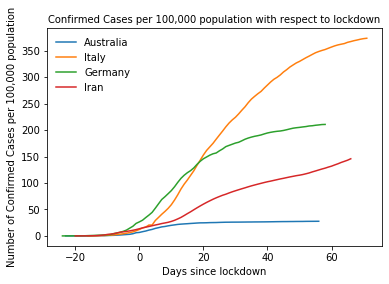

In [777]:
# Select the four countries
confirmed_australia = df_new.loc[:,'confirmed_cases_rate']
confirmed_italy = df2_new.loc[:,'confirmed_cases_rate']
confirmed_germany = df3_new.loc[:,'confirmed_cases_rate']
confirmed_iran = df4_new.loc[:,'confirmed_cases_rate']

# Plot with different colors
plt.plot(df_new.loc[:,'days_since_lockdown'], confirmed_australia, label='Australia')
plt.plot(df2_new.loc[:,'days_since_lockdown'], confirmed_italy, label='Italy')
plt.plot(df3_new.loc[:,'days_since_lockdown'], confirmed_germany, label='Germany')
plt.plot(df4_new.loc[:,'days_since_lockdown'], confirmed_iran, label='Iran')

# Create legend, title, labels
plt.legend(loc='upper left', frameon = False)
plt.title("Confirmed Cases per 100,000 population with respect to lockdown", fontsize = 10)
plt.xlabel('Days since lockdown')
plt.ylabel('Number of Confirmed Cases per 100,000 population')

Italy seems to have the highest number of confirmed cases per 100,000 population with respect to days since lockdown, followed by Germany, Iran and Australia

Text(0, 0.5, 'Number of Death Cases per 100,000 population')

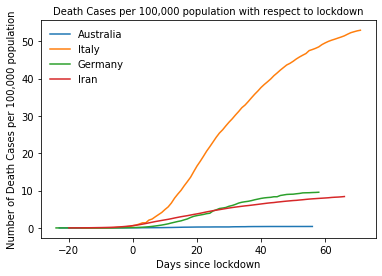

In [778]:
# Select the four countries
confirmed_australia = df_new.loc[:,'death_rate']
confirmed_italy = df2_new.loc[:,'death_rate']
confirmed_germany = df3_new.loc[:,'death_rate']
confirmed_iran = df4_new.loc[:,'death_rate']

# Plot with different colors
plt.plot(df_new.loc[:,'days_since_lockdown'], confirmed_australia, label='Australia')
plt.plot(df2_new.loc[:,'days_since_lockdown'], confirmed_italy, label='Italy')
plt.plot(df3_new.loc[:,'days_since_lockdown'], confirmed_germany, label='Germany')
plt.plot(df4_new.loc[:,'days_since_lockdown'], confirmed_iran, label='Iran')

# Create legend, title, labels
plt.legend(loc='upper left', frameon = False)
plt.title("Death Cases per 100,000 population with respect to lockdown", fontsize = 10)
plt.xlabel('Days since lockdown')
plt.ylabel('Number of Death Cases per 100,000 population')

Italy seems to have the highest number of deaths per 100,000 population with respect to days since lockdown, followed by Germany, Iran (Germany has slightly higher than Iran) and Australia

# Modeling and Curve Fitting

### Using Random Forest Regression,

#### For Germany,

In [779]:
days_df_new = df3_new.copy()

# Store the original days_since_lockdown for plotting the predicitons
original_days_df_new = days_df_new['days_since_lockdown']

days_df_new.tail()

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown,confirmed_cases_rate,death_rate
78,Germany,2020-05-14,174478,7884,380,23,79,54,208.247542,9.409918
79,Germany,2020-05-15,175233,7897,755,13,80,55,209.148670,9.425434
80,Germany,2020-05-16,175752,7938,519,41,81,56,209.768120,9.474369
81,Germany,2020-05-17,176369,7962,617,24,82,57,210.504538,9.503014
82,Germany,2020-05-18,176551,8003,182,41,83,58,210.721763,9.551950


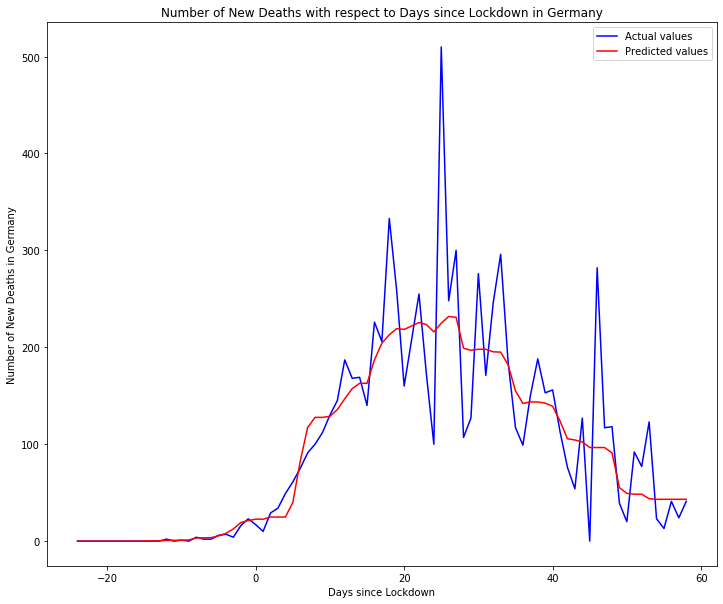

In [780]:
days = days_df_new['days_since_lockdown'].values
nd = days_df_new["new_deaths"].values

days = np.reshape(days, (len(days), 1))
nd = np.ravel(nd)

rfr = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 5,
                            max_features = "auto", criterion = "mae")
rfr.fit(days, nd)

plt.figure(figsize = (12,10))
plt.plot(days, nd, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, rfr.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of New Deaths with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Deaths in Germany')
plt.legend()
plt.show()

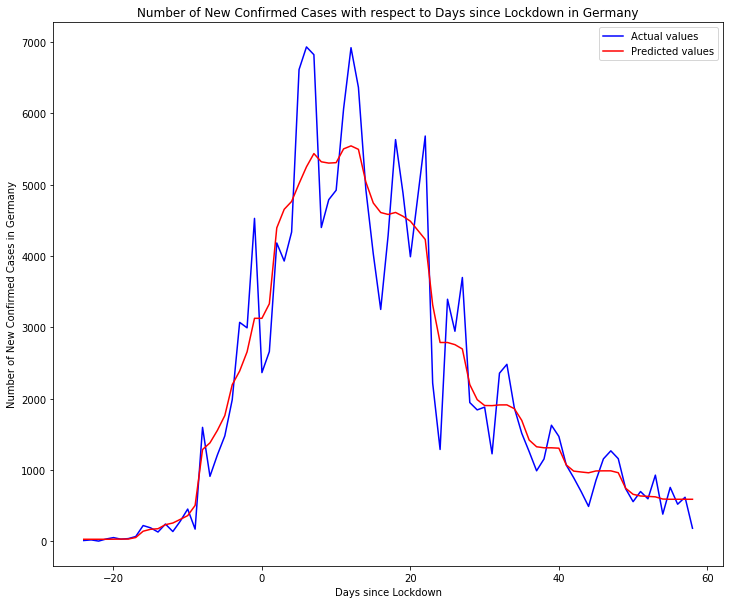

In [781]:
days = days_df_new['days_since_lockdown'].values
nc = days_df_new["new_confirmed"].values

days = np.reshape(days, (len(days), 1))
nc = np.ravel(nc)

rfr2 = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 4,
                            max_features = "auto", criterion = "mae")
rfr2.fit(days, nc)

plt.figure(figsize = (12,10))
plt.plot(days, nc, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, rfr2.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of New Confirmed Cases with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Confirmed Cases in Germany')
plt.legend()
plt.show()

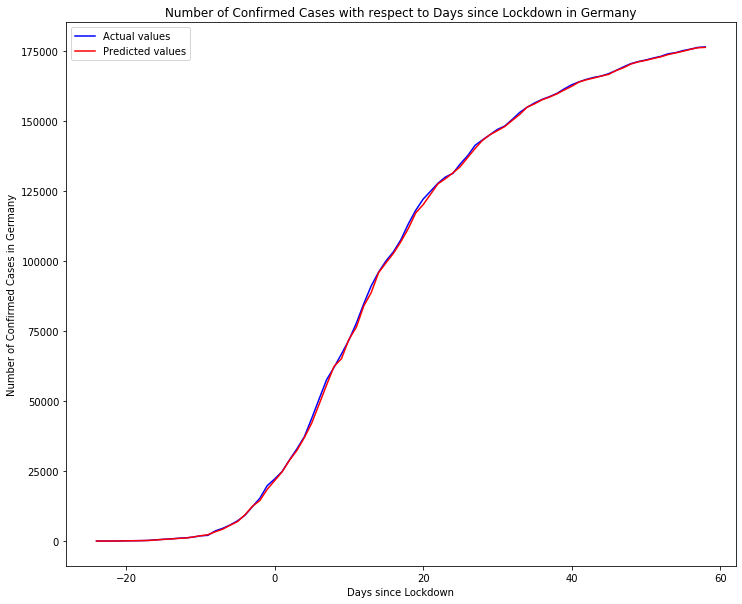

In [782]:
days = days_df_new['days_since_lockdown'].values
c = days_df_new["confirmed"].values

days = np.reshape(days, (len(days), 1))
c = np.ravel(c)

rfr3 = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 1,
                            max_features = "auto", criterion = "mae")
rfr3.fit(days, c)

plt.figure(figsize = (12,10))
plt.plot(days, c, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, rfr3.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of Confirmed Cases with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Confirmed Cases in Germany')
plt.legend()
plt.show()

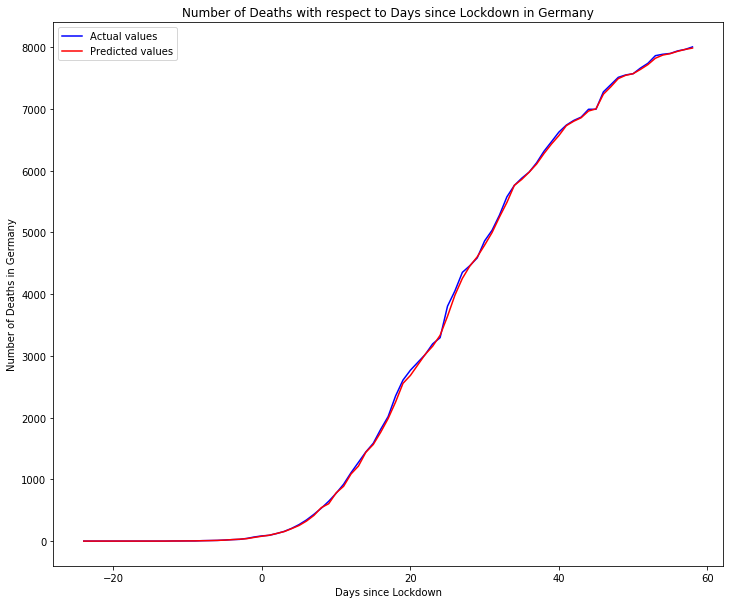

In [783]:
days = days_df_new['days_since_lockdown'].values
d = days_df_new["deaths"].values

days = np.reshape(days, (len(days), 1))
d = np.ravel(d)

rfr4 = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 1,
                            max_features = "auto", criterion = "mae")
rfr4.fit(days, d)

plt.figure(figsize = (12,10))
plt.plot(days, d, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, rfr4.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of Deaths with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Deaths in Germany')
plt.legend()
plt.show()

#### For Iran,

In [784]:
days_df2_new = df4_new.copy()

# Store the original dates for plotting the predicitons
original_days_df2_new = days_df2_new['days_since_lockdown']

days_df2_new.tail()

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,days_since_lockdown,confirmed_cases_rate,death_rate
82,Iran,2020-05-14,114533,6854,1808,71,83,62,136.360256,8.160209
83,Iran,2020-05-15,116635,6902,2102,48,84,63,138.862847,8.217356
84,Iran,2020-05-16,118392,6937,1757,35,85,64,140.954689,8.259027
85,Iran,2020-05-17,120198,6988,1806,51,86,65,143.104869,8.319746
86,Iran,2020-05-18,122492,7057,2294,69,87,66,145.836051,8.401896


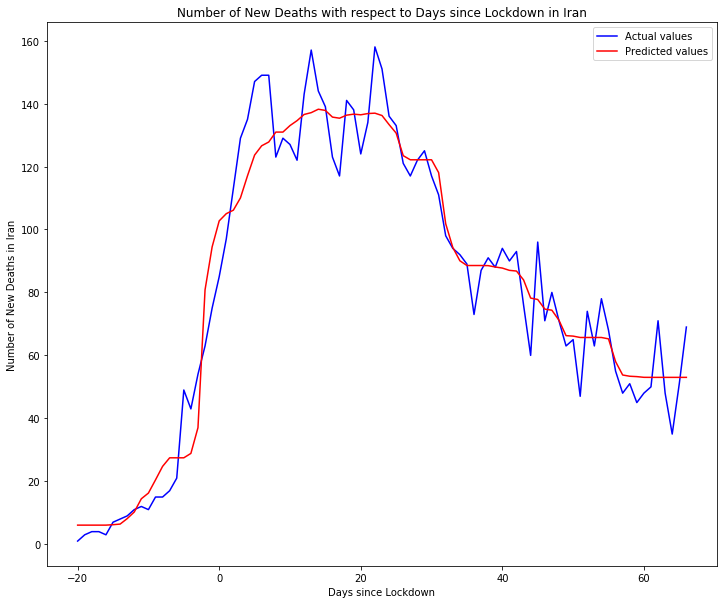

In [785]:
days2 = days_df2_new['days_since_lockdown'].values
nd2 = days_df2_new["new_deaths"].values

days2 = np.reshape(days2, (len(days2), 1))
nd2 = np.ravel(nd2)

rfr5 = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 5,
                            max_features = "auto", criterion = "mse")
rfr5.fit(days2, nd2)

plt.figure(figsize = (12,10))
plt.plot(days2, nd2, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, rfr5.predict(days2), color= 'red', label= 'Predicted values') 
plt.title('Number of New Deaths with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Deaths in Iran')
plt.legend()
plt.show()

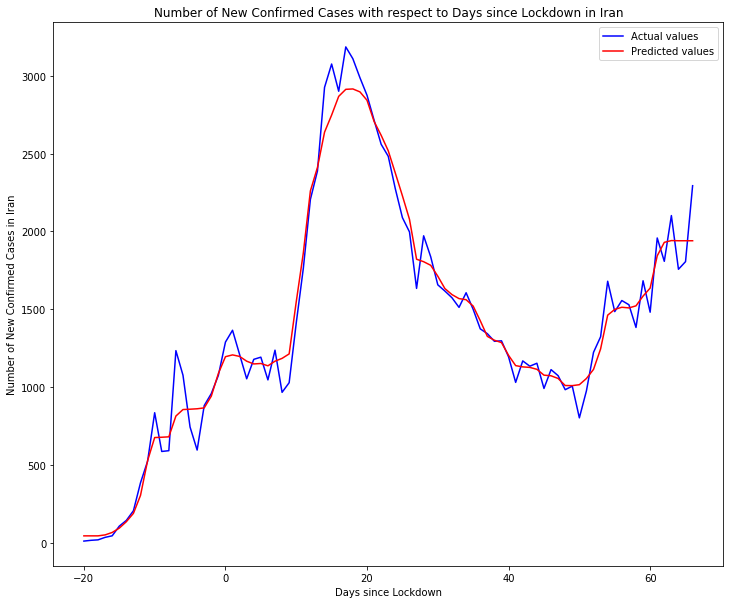

In [786]:
days2 = days_df2_new['days_since_lockdown'].values
nc2 = days_df2_new["new_confirmed"].values

days2 = np.reshape(days2, (len(days2), 1))
nc2 = np.ravel(nc2)

rfr6 = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 3,
                            max_features = "auto", criterion = "mse")
rfr6.fit(days2, nc2)

plt.figure(figsize = (12,10))
plt.plot(days2, nc2, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, rfr6.predict(days2), color= 'red', label= 'Predicted values') 
plt.title('Number of New Confirmed Cases with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Confirmed Cases in Iran')
plt.legend()
plt.show()

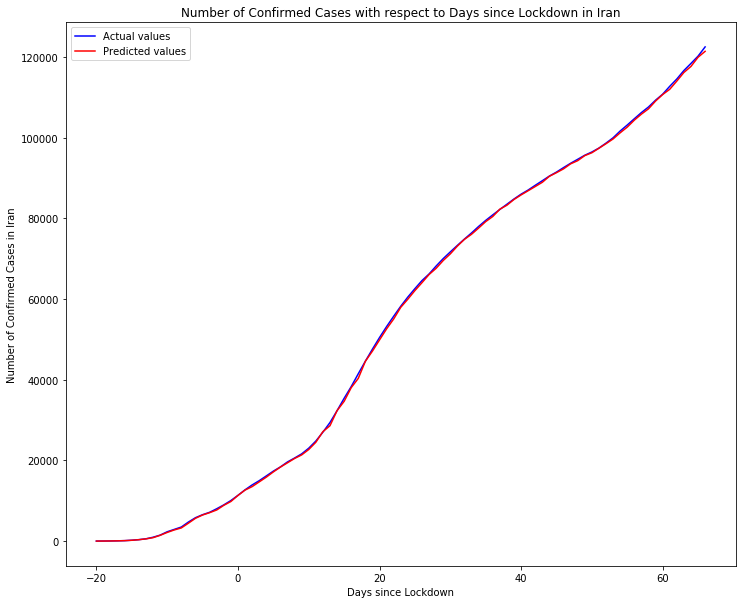

In [787]:
days2 = days_df2_new['days_since_lockdown'].values
c2 = days_df2_new["confirmed"].values

days2 = np.reshape(days2, (len(days2), 1))
c2 = np.ravel(c2)

rfr7 = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 1,
                            max_features = "auto", criterion = "mse")
rfr7.fit(days2, c2)

plt.figure(figsize = (12,10))
plt.plot(days2, c2, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, rfr7.predict(days2), color= 'red', label= 'Predicted values') 
plt.title('Number of Confirmed Cases with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Confirmed Cases in Iran')
plt.legend()
plt.show()

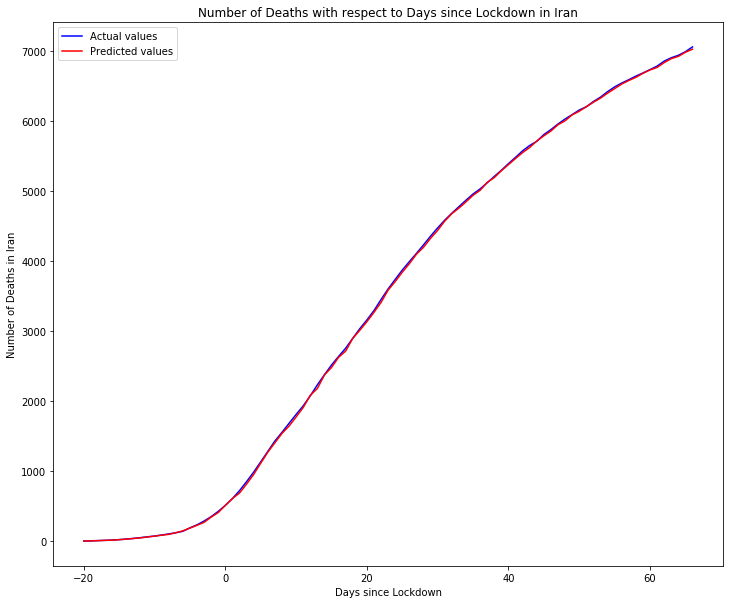

In [788]:
days2 = days_df2_new['days_since_lockdown'].values
d2 = days_df2_new["deaths"].values

days2 = np.reshape(days2, (len(days2), 1))
d2 = np.ravel(d2)

rfr8 = RandomForestRegressor(n_estimators=50, random_state = 0, oob_score = True, min_samples_leaf = 1,
                            max_features = "auto", criterion = "mse")
rfr8.fit(days2, d2)

plt.figure(figsize = (12,10))
plt.plot(days2, d2, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, rfr8.predict(days2), color= 'red', label= 'Predicted values') 
plt.title('Number of Deaths with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Deaths in Iran')
plt.legend()
plt.show()

### Using Support Vector Regression,

#### For Germany,

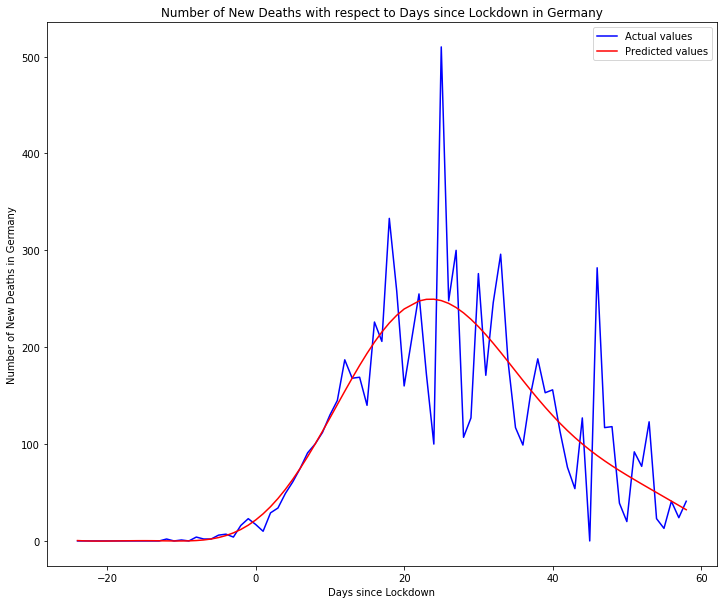

In [789]:
days = days_df_new['days_since_lockdown'].values
nd3 = days_df_new["new_deaths"].values

days = np.reshape(days, (len(days), 1))
nd3 = np.ravel(nd3)

svr_rbf = SVR(kernel= 'rbf', C= 1000, gamma= "scale")
svr_rbf.fit(days, nd3)

plt.figure(figsize = (12,10))
plt.plot(days, nd3, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, svr_rbf.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of New Deaths with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Deaths in Germany')
plt.legend()
plt.show()

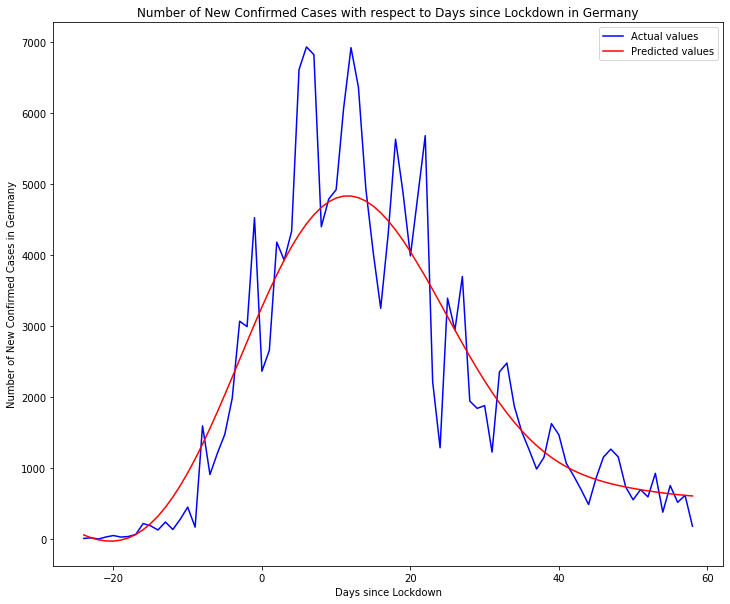

In [790]:
days = days_df_new['days_since_lockdown'].values
nc3 = days_df_new["new_confirmed"].values

days = np.reshape(days, (len(days), 1))
nc3 = np.ravel(nc3)

svr_rbf2 = SVR(kernel= 'rbf', C= 1000, gamma= "scale")
svr_rbf2.fit(days, nc3)

plt.figure(figsize = (12,10))
plt.plot(days, nc3, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, svr_rbf2.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of New Confirmed Cases with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Confirmed Cases in Germany')
plt.legend()
plt.show()

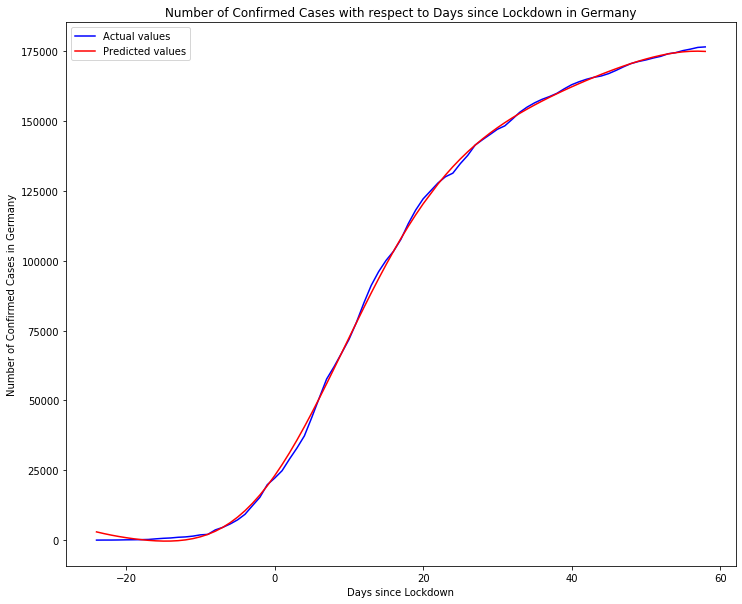

In [791]:
days = days_df_new['days_since_lockdown'].values
c3 = days_df_new["confirmed"].values

days = np.reshape(days, (len(days), 1))
c3 = np.ravel(c3)

svr_rbf3 = SVR(kernel= 'rbf', C= 50000, gamma= "scale")
svr_rbf3.fit(days, c3)

plt.figure(figsize = (12,10))
plt.plot(days, c3, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, svr_rbf3.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of Confirmed Cases with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Confirmed Cases in Germany')
plt.legend()
plt.show()

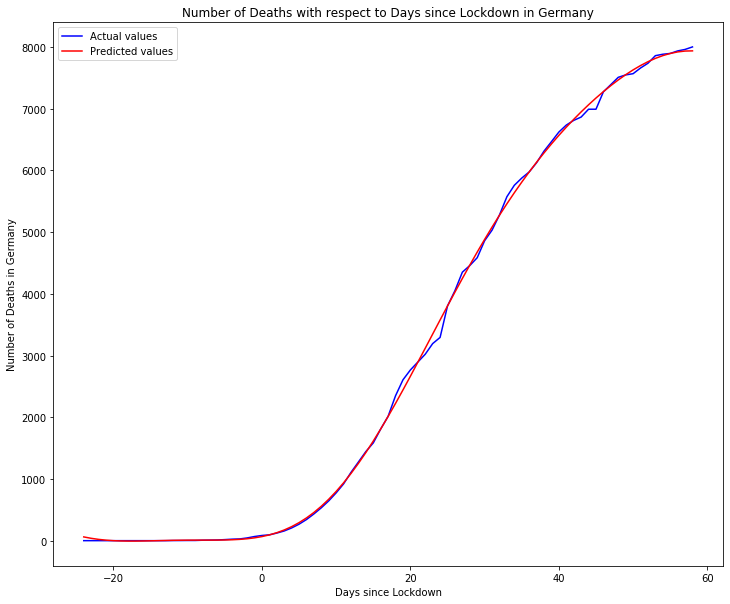

In [792]:
days = days_df_new['days_since_lockdown'].values
d3 = days_df_new["deaths"].values

days = np.reshape(days, (len(days), 1))
d3 = np.ravel(d3)

svr_rbf4 = SVR(kernel= 'rbf', C= 2000, gamma= "scale")
svr_rbf4.fit(days, d3)

plt.figure(figsize = (12,10))
plt.plot(days, d3, color= 'blue', label= 'Actual values')
plt.plot(original_days_df_new, svr_rbf4.predict(days), color= 'red', label= 'Predicted values') 
plt.title('Number of Deaths with respect to Days since Lockdown in Germany')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Deaths in Germany')
plt.legend()
plt.show()

#### For Iran,

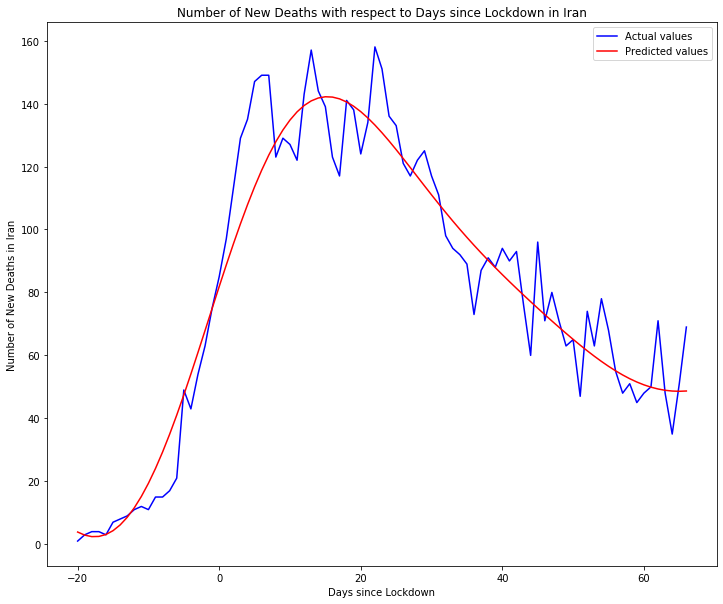

In [793]:
days2 = days_df2_new['days_since_lockdown'].values
nd4 = days_df2_new["new_deaths"].values

days2 = np.reshape(days2, (len(days2), 1))
nd4 = np.ravel(nd4)

svr_rbf_5 = SVR(kernel= 'rbf', C= 100, gamma= "scale")
svr_rbf_5.fit(days2, nd4)

plt.figure(figsize = (12,10))
plt.plot(days2, nd4, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, svr_rbf_5.predict(days2), color= 'red', label= 'Predicted values')
plt.title('Number of New Deaths with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Deaths in Iran')
plt.legend()
plt.show()

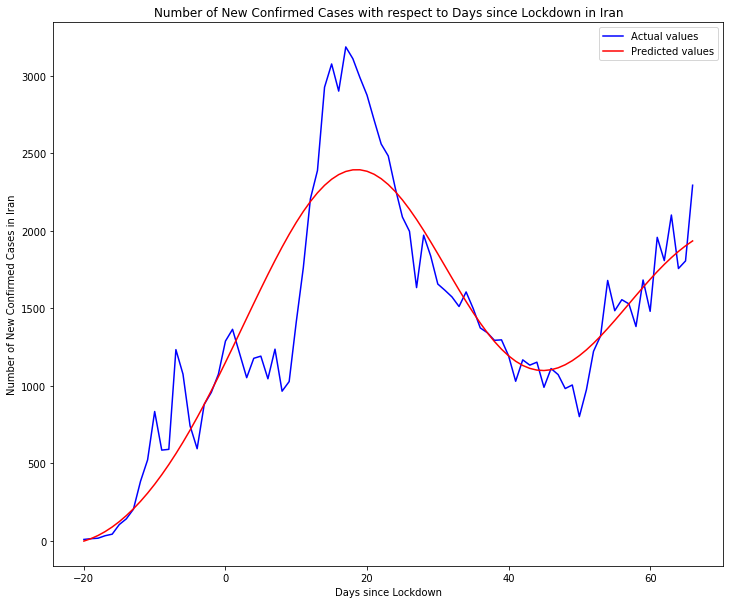

In [794]:
days2 = days_df2_new['days_since_lockdown'].values
nc4 = days_df2_new["new_confirmed"].values

days2 = np.reshape(days2, (len(days2), 1))
nc4 = np.ravel(nc4)

svr_rbf_6 = SVR(kernel= 'rbf', C= 1000, gamma= "scale")
svr_rbf_6.fit(days2, nc4)

plt.figure(figsize = (12,10))
plt.plot(days2, nc4, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, svr_rbf_6.predict(days2), color= 'red', label= 'Predicted values')
plt.title('Number of New Confirmed Cases with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of New Confirmed Cases in Iran')
plt.legend()
plt.show()

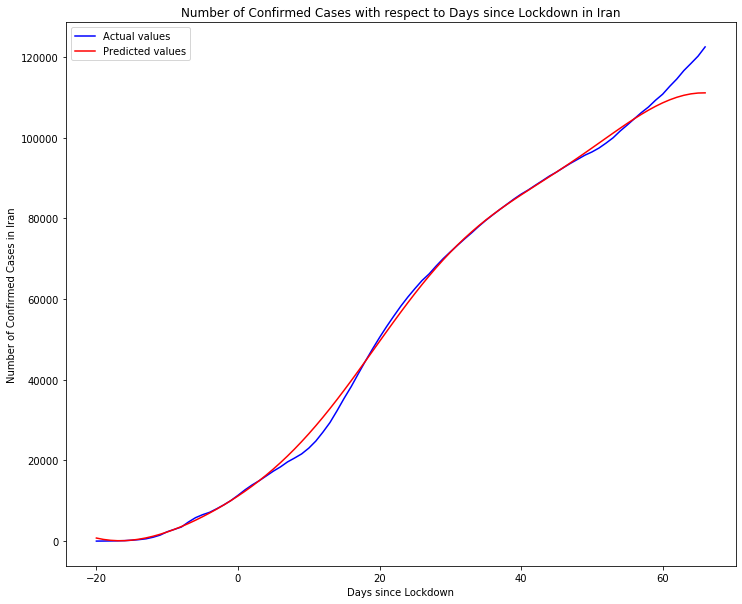

In [795]:
days2 = days_df2_new['days_since_lockdown'].values
c4 = days_df2_new["confirmed"].values

days2 = np.reshape(days2, (len(days2), 1))
c4 = np.ravel(c4)

svr_rbf_7 = SVR(kernel= 'rbf', C= 10000, gamma= "scale")
svr_rbf_7.fit(days2, c4)

plt.figure(figsize = (12,10))
plt.plot(days2, c4, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, svr_rbf_7.predict(days2), color= 'red', label= 'Predicted values')
plt.title('Number of Confirmed Cases with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Confirmed Cases in Iran')
plt.legend()
plt.show()

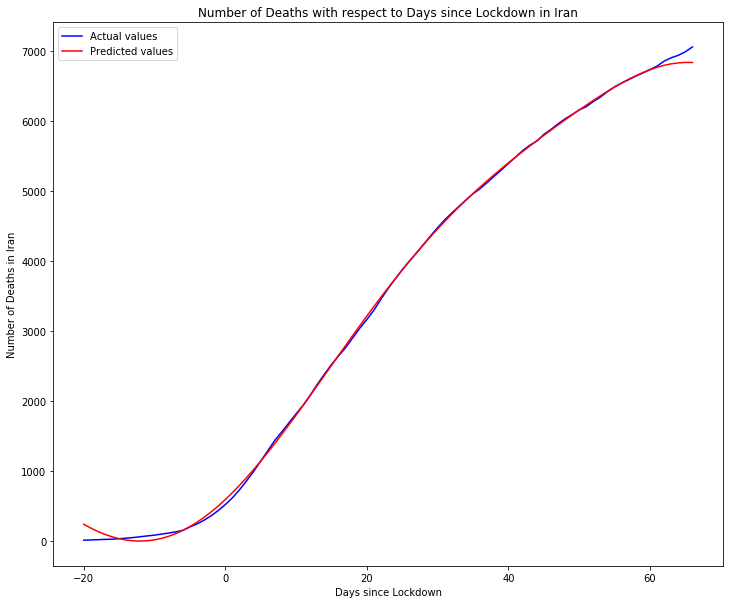

In [796]:
days2 = days_df2_new['days_since_lockdown'].values
d4 = days_df2_new["deaths"].values

days2 = np.reshape(days2, (len(days2), 1))
d4 = np.ravel(d4)

svr_rbf_7 = SVR(kernel= 'rbf', C= 1000, gamma= "scale")
svr_rbf_7.fit(days2, d4)

plt.figure(figsize = (12,10))
plt.plot(days2, d4, color= 'blue', label= 'Actual values')
plt.plot(original_days_df2_new, svr_rbf_7.predict(days2), color= 'red', label= 'Predicted values')
plt.title('Number of Deaths with respect to Days since Lockdown in Iran')
plt.xlabel('Days since Lockdown')
plt.ylabel('Number of Deaths in Iran')
plt.legend()
plt.show()

### We observe that we get smoother curves when using Support Vector Regression as compared to Random Forest Regression. We also observe that Iran has a second wave of new confirmed cases with the second curve on the rise